<a href="https://colab.research.google.com/github/amin-tayebi/Attack-Detection-in-IoT-Network-Teraffic-with-Neural-network-Deep-Learning-model/blob/main/ex5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN vs MLP
In this notebook it will be showed how to train a CNN and what are its advantages (and disanvantages) with respect to a fully connected network.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy

In [2]:
# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

## Dataset Loading
First step we need to load the dataset that will be used for train and test.

In this case MNIST dataset will be used. MNIST consist in black and white images of handwritten digits between 0-9.

Pytorch Dataloaders will be used for this task.

In [3]:
input_size  = 28*28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

# TRAIN dataset
# Pytorch already has some datasets available for downlaod
train_dataset = datasets.MNIST('../data', train=True, download=True, 
                       # transforms that we want to apply when iterating the dataset
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       # mean and std of MNIST dataset
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

# The datasoar will iterate through the dataset and load the data in memory
train_loader = torch.utils.data.DataLoader(
                        train_dataset,
                        batch_size=64, shuffle=True)

# TEST dataset
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [4]:
print(len(train_dataset), len(train_loader)) #WHY?

60000 938


In [5]:
# plotting libs
#from res.plot_lib import plot_data, plot_model, set_default
#set_default()

ModuleNotFoundError: ignored

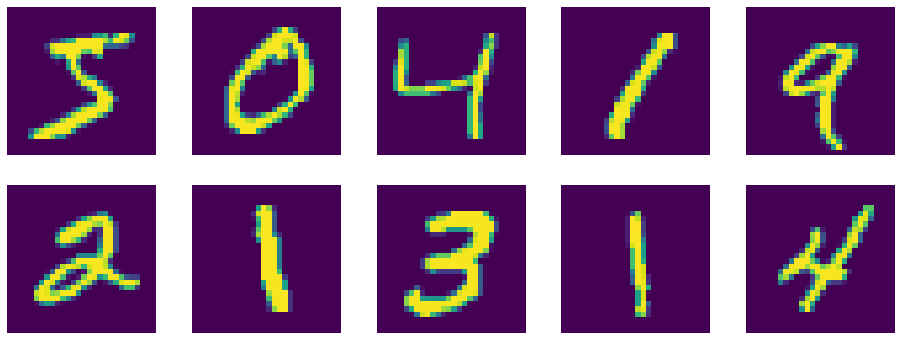

In [6]:
# show some images
def denorm_mnist(x):
    m = 0.1307
    std = 0.3081
    # denormalization operation = std*x + m
    return x*std + m

to_pil = transforms.ToPILImage()
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i) # load one image
    plt.imshow(to_pil(denorm_mnist(image)))
    plt.axis('off');

## Network Definition
Let's define and MLP and a CNN to solve the MNIST digit classification task.

In [7]:
# MLP
class FC2Layer(nn.Module):
    def __init__(self, input_size, n_hidden, output_size):
        super(FC2Layer, self).__init__()
        self.input_size = input_size
        self.network = nn.Sequential(
            nn.Linear(input_size, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, n_hidden), 
            nn.ReLU(), 
            nn.Linear(n_hidden, output_size), 
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = x.view(-1, self.input_size) # flatten
        return self.network(x)

# CNN
class CNN(nn.Module):
    def __init__(self, input_size, n_feature, output_size):
        super(CNN, self).__init__()
        self.n_feature = n_feature
        
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=n_feature, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=n_feature, out_channels=n_feature, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2))

        self.fc1 = nn.Linear(n_feature*4*4, 50)
        self.fc2 = nn.Linear(50, 10)
        
    def forward(self, x, verbose=False):
        x = self.conv_block1(x) # what is the output size?
        x = self.conv_block2(x) # what is the output size?
        x = x.view(-1, self.n_feature*4*4) # flatten
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [8]:
# set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [9]:
# define train and test function
accuracy_list = []
def train(epoch, model, optimizer, perm=None): #perm = torch.arange(0, 784).long()
    model.train()
    # dataloader will iterate the dataset and return images (data)
    # and labels (target)
    for batch_idx, (data, target) in enumerate(train_loader):
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
def test(model, perm=None): #perm = torch.arange(0, 784).long()
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        data = data.view(-1, 28*28)
        data = data[:, perm]
        data = data.view(-1, 1, 28, 28)
        output = model(data)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        accuracy))

In [10]:
n_hidden = 8 # number of hidden units

model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 1):
    train(epoch, model_fnn, optimizer)
    test(model_fnn)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.302990
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.046771
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.532380
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.766227
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.730893
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.922921
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.462277
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.421554
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.489059
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.463484

Test set: Average loss: 0.4081, Accuracy: 8847/10000 (88%)



In [11]:
# Training settings 
n_features = 6 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn, optimizer)
    test(model_cnn)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.295907
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.160846
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.565181
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.483501
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.257377
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.179134
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.387993
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.150592
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.201404
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.071292

Test set: Average loss: 0.1683, Accuracy: 9469/10000 (95%)



The CNN performs much better that an MLP on images.

Now let's try to shuffle the pixels!

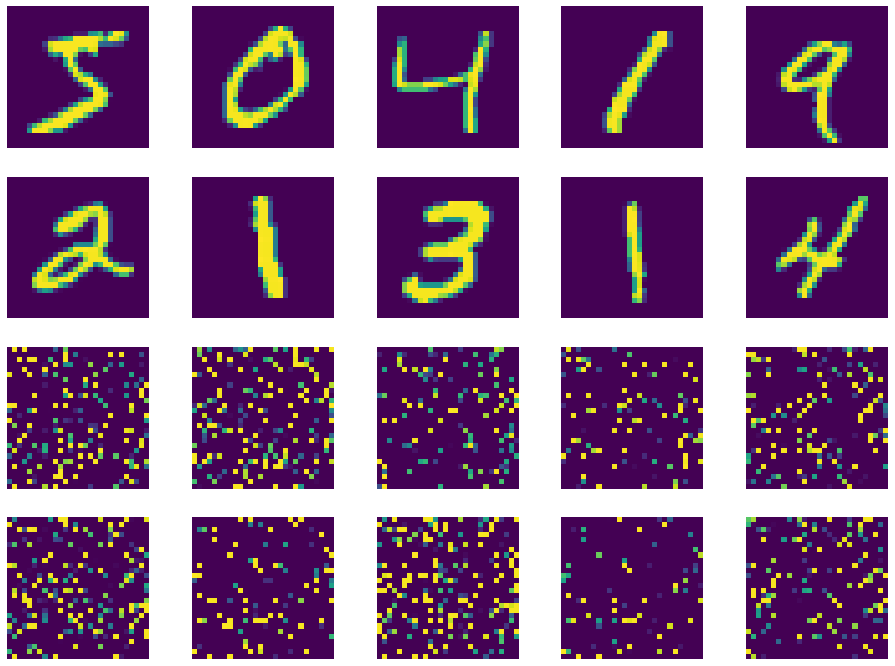

In [12]:
perm = torch.randperm(784)
plt.figure(figsize=(16, 12))
for i in range(10):
    image, _ = train_loader.dataset.__getitem__(i)
    # permute pixels
    image_perm = image.view(-1, 28*28).clone()
    image_perm = image_perm[:, perm]
    image_perm = image_perm.view(-1, 1, 28, 28)
    plt.subplot(4, 5, i + 1)
    plt.imshow(to_pil(denorm_mnist(image.squeeze())))
    plt.axis('off')
    plt.subplot(4, 5, i + 11)
    plt.imshow(to_pil(denorm_mnist(image_perm.squeeze())))
    plt.axis('off')

### How the CNN will perform now?

In [13]:
# Training settings 
n_features = 6 # number of feature maps

model_cnn = CNN(input_size, n_features, output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

for epoch in range(0, 1):
    train(epoch, model_cnn, optimizer, perm)
    test(model_cnn, perm)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.292637
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.249465
Train Epoch: 0 [12800/60000 (21%)]	Loss: 2.087557
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.483956
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1.194530
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.652478
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.792482
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.741226
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.691363
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.677042

Test set: Average loss: 0.5579, Accuracy: 8255/10000 (83%)



### How about the MLP?

In [14]:
n_hidden = 8    # number of hidden units

model_fnn = FC2Layer(input_size, n_hidden, output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range(0, 1):
    train(epoch, model_fnn, optimizer, perm)
    test(model_fnn, perm)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.325194
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.643883
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.033113
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.780929
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.942963
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.449180
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.766237
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.495336
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.299693
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.364883

Test set: Average loss: 0.4296, Accuracy: 8727/10000 (87%)



### The CNN performances dropped!!!
WHY? The concept of locality was lost: pixel are no longer stationary on a grid

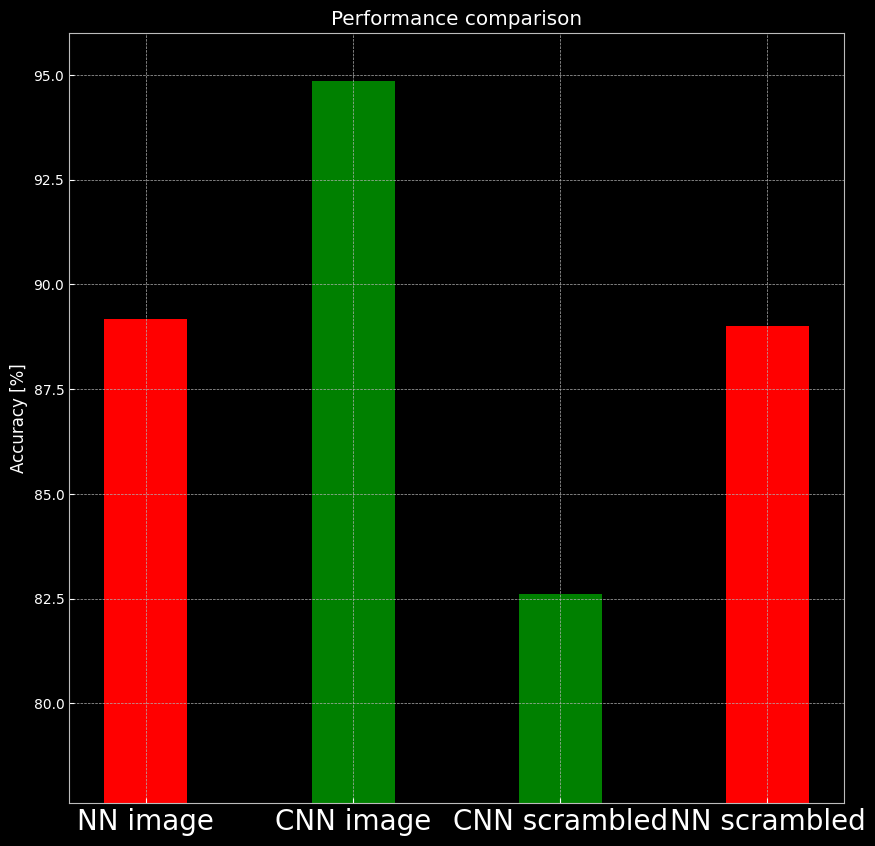

In [ ]:
plt.bar(('NN image', 'CNN image',
         'CNN scrambled', 'NN scrambled'),
        accuracy_list, width=0.4, color = ['red', 'green', 'green', 'red'])
plt.ylim((min(accuracy_list)-5, 96))
plt.ylabel('Accuracy [%]')
for tick in plt.gca().xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
plt.title('Performance comparison');